Dint use **UDA and smoothening**

###1. SetUp

####1.1 Imports

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import os

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

####1.2 Device agnostic code

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

####1.3 Hyperparameters

In [51]:
MU = 11.5
BATCH_SIZE = 128
SEED = 42
EPOCHS = 15
BETA_ZERO = 8
a = 5000

###2. Data

####2.1 Get the data

In [7]:
def get_cifar10_data():
  from torchvision import datasets
  from torchvision.datasets import ImageFolder

  train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
  )

  test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
  )
  return (train_data , test_data)

In [8]:
train_data , test_data = get_cifar10_data()
train_data , test_data

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train,
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test)

#### Visualize

In [9]:
def visualize(dir):
  import random
  random_index = random.randint(0, len(dir) - 1)
  image, label = dir[random_index]
  plt.figure(figsize=(10,5))
  plt.title(label)
  plt.imshow(image)
  plt.axis(False)

TypeError: object of type 'bool' has no len()

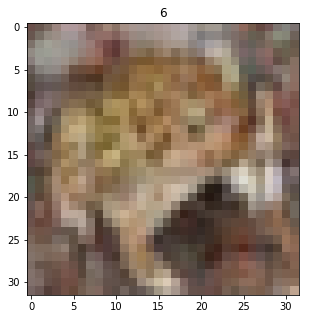

In [10]:
visualize(train_data)

#### 2.2 Organize the data

In [11]:
def load_batches(file_path):
  import os
  import pickle
  with open(file_path, 'rb') as fo:
    batch = pickle.load(fo, encoding='bytes')
  return batch

In [12]:
meta_path = 'data/cifar-10-batches-py/batches.meta'
meta = load_batches(meta_path)
meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [13]:
def create_classification_directory(input_dir,output_dir,subdirectory):
  import os
  os.makedirs(output_dir, exist_ok=True)
  for label_id, class_name in enumerate(subdirectory):
    class_name = class_name.decode('utf-8')
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

In [14]:
### Train directory
input_dir = 'data/cifar-10-batches-py'
output_dir = 'cifar-10-dataset'
subdirectory = meta[b'label_names']
create_classification_directory(input_dir,output_dir,subdirectory)

In [15]:
### Test directory
input_dir = 'data/cifar-10-batches-py'
output_dir = 'test'
subdirectory = meta[b'label_names']
create_classification_directory(input_dir,output_dir,subdirectory)

In [16]:
### Copy train Data
def Copy_train_Images(input_dir,output_dir):
  import os
  for batch_id in range(1, 6):
    batch_data = load_batches(os.path.join(input_dir, f'data_batch_{batch_id}'))
    for i, (image, label) in enumerate(zip(batch_data[b'data'], batch_data[b'labels'])):
      class_name = meta[b'label_names'][label].decode('utf-8')
      image = image.reshape(3, 32, 32).transpose(1, 2, 0)
      image_filename = f'{batch_id}_{i + 1}.png'
      output_path = os.path.join(output_dir, class_name, image_filename)
      plt.imsave(output_path, image)

In [18]:
output_dir = 'cifar-10-dataset'
input_dir = 'data/cifar-10-batches-py'
Copy_train_Images(input_dir,output_dir)

In [19]:
def Images_in_directory(input_dir):
  from pathlib import Path
  dir = Path(input_dir)
  num_items = len(list(dir.glob('*/*.png')))
  print(f"Number of items in {dir} directory: {num_items}")

In [20]:
Images_in_directory('cifar-10-dataset')

Number of items in cifar-10-dataset directory: 50000


In [21]:
### Copy test Data
def Copy_test_Images(input_dir,output_dir):
  import os
  batch_data = load_batches(os.path.join(input_dir, 'test_batch'))
  for i, (image, label) in enumerate(zip(batch_data[b'data'], batch_data[b'labels'])):
        class_name = meta[b'label_names'][label].decode('utf-8')
        image = image.reshape(3, 32, 32).transpose(1, 2, 0)
        image_filename = f'{i + 1}.png'
        output_path = os.path.join(output_dir, class_name, image_filename)
        plt.imsave(output_path, image)

In [22]:
output_dir = 'test'
input_dir = 'data/cifar-10-batches-py'
Copy_test_Images(input_dir,output_dir)

In [23]:
Images_in_directory('test')

Number of items in test directory: 10000


In [24]:
def simple_dataset(input_dir):
  from torchvision import datasets
  data = datasets.ImageFolder(root=input_dir)
  return data

In [25]:
data = simple_dataset('cifar-10-dataset')
data

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: cifar-10-dataset

####2.3 Labeled and Unlabeled Split

In [26]:
labeled_ratio = 1/(MU+1)
labeled_ratio

0.08

In [27]:
def get_subdirectories(parent_dir):
  import os
  from pathlib import Path
  for subdirectory in os.listdir(parent_dir):
    subdirectory_path = os.path.join(parent_dir, subdirectory)
    if os.path.isdir(subdirectory_path):
        print("Subdirectory:", subdirectory_path)
  parent_dir = Path(parent_dir)
  subdirectories = [subdir for subdir in parent_dir.iterdir() if subdir.is_dir()]
  return subdirectories

In [28]:
sub_directories = get_subdirectories('cifar-10-dataset')
sub_directories

Subdirectory: cifar-10-dataset/truck
Subdirectory: cifar-10-dataset/horse
Subdirectory: cifar-10-dataset/ship
Subdirectory: cifar-10-dataset/frog
Subdirectory: cifar-10-dataset/bird
Subdirectory: cifar-10-dataset/deer
Subdirectory: cifar-10-dataset/dog
Subdirectory: cifar-10-dataset/automobile
Subdirectory: cifar-10-dataset/airplane
Subdirectory: cifar-10-dataset/cat


[PosixPath('cifar-10-dataset/truck'),
 PosixPath('cifar-10-dataset/horse'),
 PosixPath('cifar-10-dataset/ship'),
 PosixPath('cifar-10-dataset/frog'),
 PosixPath('cifar-10-dataset/bird'),
 PosixPath('cifar-10-dataset/deer'),
 PosixPath('cifar-10-dataset/dog'),
 PosixPath('cifar-10-dataset/automobile'),
 PosixPath('cifar-10-dataset/airplane'),
 PosixPath('cifar-10-dataset/cat')]

In [29]:
def l_u_split(seed,source,l,u,ratio):
  import numpy as np
  np.random.seed(seed)
  torch.manual_seed(seed)

  import os
  import random
  from pathlib import Path

  source_dir = Path(source)
  labeled_dir = Path(l)
  unlabeled_dir = Path(u)

  labeled_dir.mkdir(parents=True, exist_ok=True)
  unlabeled_dir.mkdir(parents=True, exist_ok=True)

  split_ratio = ratio


  for class_name in os.listdir(source_dir):
    class_dir = source_dir / class_name

    labeled_class_dir = labeled_dir / class_name
    labeled_class_dir.mkdir(parents=True, exist_ok=True)

    unlabeled_class_dir = unlabeled_dir / class_name
    unlabeled_class_dir.mkdir(parents=True, exist_ok=True)


    image_files = list(class_dir.glob("*.png"))

    random.shuffle(image_files)

    num_labeled = int(len(image_files) * split_ratio)
    num_unlabeled = len(image_files) - num_labeled

    for i in range(num_labeled):
        src_path = image_files[i]
        dest_path = labeled_class_dir / src_path.name
        src_path.rename(dest_path)

    for i in range(num_labeled, num_labeled + num_unlabeled):
        src_path = image_files[i]
        dest_path = unlabeled_class_dir / src_path.name
        src_path.rename(dest_path)

In [30]:
l_u_split(SEED,'cifar-10-dataset','labeled','unlabeled',labeled_ratio)

In [31]:
Images_in_directory('labeled')

Number of items in labeled directory: 14794


In [32]:
Images_in_directory('unlabeled')

Number of items in unlabeled directory: 49928


####2.4 Transforms

In [33]:
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip,RandomAffine

transform = transforms.Compose([transforms.AutoAugment(),
                               transforms.RandAugment(),
    transforms.Resize((32, 32)),
    transforms.RandomAutocontrast(p= 0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.2),
    transforms.RandomResizedCrop(size=(32,32)),
    transforms.RandomEqualize(p= 0.5),
    transforms.RandomInvert(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5),
    transforms.RandomAffine(degrees=12.5,translate=[0.5,0.5],shear=[0.5,0.5]),
    transforms.RandomRotation(degrees=12.5),
    transforms.RandomPosterize(bits=8,p= 0.5),
    transforms.RandomSolarize(threshold = 0.5,p= 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

simple_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

####2.5 Dataset

In [34]:
from torchvision.datasets import ImageFolder

labeled_dir = 'labeled'
unlabeled_dir = 'unlabeled'
test_dir = 'test'

labeled_data = ImageFolder(root=labeled_dir,transform=transform)
unlabeled_data = ImageFolder(root=unlabeled_dir,transform=simple_transform)
unlabeled_data_augmented = ImageFolder(root=unlabeled_dir,transform=transform)
test_data = ImageFolder(root=test_dir,transform=transform)



####2.6 DataLoader

In [35]:
from torch.utils.data import DataLoader

labeled_train_loader = DataLoader(labeled_data, batch_size=BATCH_SIZE, shuffle=False)
unlabeled_train_loader = DataLoader(unlabeled_data, batch_size=BATCH_SIZE, shuffle=False)
unlabeled_train_loader_augmented = DataLoader(unlabeled_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=True)

In [36]:
print(f"Labeled:{len(labeled_train_loader)} | Unlabeled_Augmented:{len(unlabeled_train_loader_augmented)} | Unlabeled:{len(unlabeled_train_loader)} | Test:{len(test_loader)}")

Labeled:116 | Unlabeled_Augmented:391 | Unlabeled:391 | Test:79


###3. Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import sys
import numpy as np

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

if __name__ == '__main__':
    net=Wide_ResNet(28, 2, 0.3, 10)
    y = net(Variable(torch.randn(1,3,32,32)))

    print(y.size())
    print(y)

###4. Train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true.to(device), y_pred.to(device)).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
def plot_loss_curves(results):
    train_loss = results["train_loss"]
    test_loss = results["model_test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["ema_test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


####Phase 1

In [71]:
torch.manual_seed(SEED)

from torchvision import models
model = Wide_ResNet(28, 2, 0.3, 10).to(device)
model

| Wide-Resnet 28x2


Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): wide_basic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): wide_basic(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32,

model = torchvision.models.efficientnet_b0()

In [76]:
model = torchvision.models.efficientnet_b0()

In [77]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5,inplace=True),
    nn.Linear(in_features=1280,out_features=10,bias=True)
)
model=model.to(device)


In [78]:
optimizer = optim.SGD(model.parameters(),lr=0.001)

In [79]:
i = 1
i = torch.tensor(i,dtype=torch.float32)
a = 8
a = torch.tensor(a,dtype=torch.float32)
print("i",i)
print("a",a)

i tensor(1.)
a tensor(8.)


In [80]:
clipping_value = 0.8
label_smoothing_constant = 0.15

In [ ]:
epochs = EPOCHS
beta_zero = BETA_ZERO
num_epochs = epochs
labeled_batches = iter(labeled_train_loader)
unlabeled_batches = iter(unlabeled_train_loader)
unlabeled_batches_augmented = iter(unlabeled_train_loader_augmented)
test_batches = iter(test_loader)

for epoch in range(num_epochs):
    acc = 0
    model.train()
    loss_per_epoch_1 = 0
    loss_per_epoch_2 = 0
    for _ in range(len(unlabeled_train_loader)):
        try:
            labeled_images, labels = next(labeled_batches)
        except StopIteration:
            labeled_batches = iter(labeled_train_loader)
            labeled_images, labels = next(labeled_batches)

        try:
            unlabeled_images, _ = next(unlabeled_batches)
        except StopIteration:
            unlabeled_batches = iter(unlabeled_train_loader)
            unlabeled_images, _ = next(unlabeled_batches)

        try:
            unlabeled_images_augmented, _ = next(unlabeled_batches_augmented)
        except StopIteration:
            unlabeled_batches_augmented = iter(unlabeled_train_loader_augmented)
            unlabeled_images_augmented, _ = next(unlabeled_batches_augmented)


        # print("Unlabeled Image Tensor : ", unlabeled_images_augmented)
        unlabeled_logits_augmented = model(unlabeled_images_augmented.to(device)).to(device)
        # print("Unlabeled Image Logits Tensor : ", unlabeled_logits_augmented)
        unlabeled_logits = model(unlabeled_images.to(device)).to(device)
        
        with torch.no_grad():
                    pseudo_labels = torch.argmax(torch.softmax(unlabeled_logits, dim=1), dim=1).to(device)

        
        labeled_logits = model(labeled_images.to(device)).to(device)

        loss_1 = nn.CrossEntropyLoss(label_smoothing = label_smoothing_constant)(unlabeled_logits_augmented,pseudo_labels)
        loss_old  = nn.CrossEntropyLoss()(labeled_logits.to(device),labels.to(device)).to(device)

        #1st pass
        optimizer.zero_grad()
        loss_1.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()


        new_labeled_logits = model(labeled_images.to(device)).to(device)
        loss_ce_y = nn.CrossEntropyLoss()(new_labeled_logits,labels.to(device)).to(device).detach()

        new_unlabeled_logits = model(unlabeled_images.to(device)).to(device)
        new_unlabeled_logits_augmented = model(unlabeled_images_augmented.to(device)).to(device)
        # print("new_unlabeled_logits", new_unlabeled_logits)
        # print("new_unlabeled_logits_augmented", new_unlabeled_logits_augmented)
        BETA_K = beta_zero * torch.min(i,((epoch+1)/a))

        loss_partial = BETA_K * torch.sum(-(torch.softmax(new_unlabeled_logits,dim=1)) * torch.log1p(torch.softmax(new_unlabeled_logits_augmented,dim=1)), dim=0).mean()
        loss_uda = loss_ce_y + loss_partial
        # print("loss_ce_y:", loss_ce_y)
        # print("loss_partial:", loss_partial)
        with torch.no_grad():
                    new_pseudo_labels = torch.argmax(torch.softmax(new_unlabeled_logits,dim=1), dim=1).to(device)


        change = loss_old.detach() - loss_ce_y.detach()
        loss_mpl = ((change)* (nn.CrossEntropyLoss()(new_unlabeled_logits,new_pseudo_labels)))
        # print("change : ",change )
        # print("The updated loss term in the end : ", nn.CrossEntropyLoss()(new_unlabeled_logits,new_pseudo_labels))

        optimizer.zero_grad()
#         print(f"Loss_OLD:{loss_old} ")
#         print(f"Loss_NEW:{loss_ce_y} ")
        # print("Loss_mpl:",loss_mpl)
        (loss_uda + loss_mpl).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()

        loss_per_epoch_1 += loss_1
        loss_per_epoch_2 += loss_uda + loss_mpl

    model.eval()
    for _ in range(len(test_loader)):
      try:
          test_images, test_labels = next(test_batches)
      except StopIteration:
          test_batches = iter(test_loader)
          test_images, test_labels = next(test_batches)

      test_logits = model(test_images.to(device))
      pred_labels = torch.argmax(torch.softmax(test_logits,dim=1).to(device),dim=1).to(device)
      acc += accuracy_fn(test_labels, pred_labels)

    print("Accuracy per epoch :", acc/len(test_loader))
    print(f"Loss_1:{loss_per_epoch_1/len(unlabeled_train_loader)} ")
    print(f"Loss_2:{loss_per_epoch_2/len(unlabeled_train_loader)} ")



Accuracy per epoch : 10.007911392405063
Loss_1:2.1125617027282715 
Loss_2:0.9512028694152832 


In [ ]:
!nvidia-smi

In [46]:
arr = torch.tensor([[1,2,3],[4,5,6]])

In [47]:
s = arr.sum(dim=0)
s

tensor([5, 7, 9])

####CNN Model

####EMA Model

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(transformer_model.parameters(),lr=0.03,weight_decay=1e-4,momentum=0.9)

NameError: name 'transformer_model' is not defined

In [ ]:
t_results,t_ema = phase1(transformer_model,labeled_train_loader,unlabeled_train_loader,optimizer,test_loader,
           confidence_threshold = threshold,MU=MU,loss_fn=loss_fn,epochs=EPOCHS,t_max=60,device=device)

In [ ]:
#plot_loss_curves(t_results)

####Phase 2

####Predictions

In [ ]:
def predictions(model1,model2,test_loader):
  results ={"model1":[],
            "model2":[]
  }
  test_batches = iter(test_loader)
  model1.eval()
  model2.eval()
  for _ in range(len(test_loader)):
        try:
            test_images, labels = next(test_batches)
        except StopIteration:
            test_batches = iter(test_loader)
            test_images, labels = next(test_batches)

        test_outputs1 = model1(test_images.to(device))
        model1_label = torch.argmax(torch.softmax(model1(test_images.to(device)), dim=1), dim=1).to(device)

        test_outputs2 = model2(test_images.to(device))
        model2_label = torch.argmax(torch.softmax(model2(test_images.to(device)), dim=1), dim=1).to(device)

  results["model1"].append(model1_label)
  results["model2"].append(model2_label)
  print(f"Model1:{model1_label} Model2:{model2_label} Label:{labels}")
  return (results)

In [ ]:
final_results = predictions(cnn_ema,t_ema,test_loader)

###Save

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    from pathlib import Path
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(cnn_ema,'models','cnn_ema.pth')
save_model(t_ema,'models','t_ema.pth')